## Linear Regression

### Added snippet used as a reference for all models

This model is based on the TuringTutorial example [LinearRegression](https://github.com/TuringLang/TuringTutorials/blob/csp/linear/LinearRegression.ipynb) by Cameron Pfiffer.

Turing is powerful when applied to complex hierarchical models, but it can also be put to task at common statistical procedures, like linear regression. This tutorial covers how to implement a linear regression model in Turing.

We begin by importing all the necessary libraries.

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, GLM
gr(size=(500,500))

ProjDir = rel_path("..", "chapters", "00")
cd(ProjDir)

We will use the mtcars dataset from the RDatasets package. mtcars contains a variety of statistics on different car models, including their miles per gallon, number of cylinders, and horsepower, among others.

We want to know if we can construct a Bayesian linear regression model to predict the miles per gallon of a car, given the other statistics it has. Lets take a look at the data we have.

Import the dataset.

In [2]:
data = RDatasets.dataset("datasets", "mtcars");

Show the first six rows of the dataset.

In [3]:
first(data, 6)

,Model,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS,AM,Gear,Carb
,String⍰,Float64⍰,Int64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,Mazda RX4,21.0,6,160.0,110,3.9,2.62,16.46,0,1,4,4
2,Mazda RX4 Wag,21.0,6,160.0,110,3.9,2.875,17.02,0,1,4,4
3,Datsun 710,22.8,4,108.0,93,3.85,2.32,18.61,1,1,4,1
4,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
5,Hornet Sportabout,18.7,8,360.0,175,3.15,3.44,17.02,0,0,3,2
6,Valiant,18.1,6,225.0,105,2.76,3.46,20.22,1,0,3,1


The next step is to get our data ready for testing. We'll split the mtcars dataset into two subsets, one for training our model and one for evaluating our model. Then, we separate the labels we want to learn (MPG, in this case) and standardize the datasets by subtracting each column's means and dividing by the standard deviation of that column.

The resulting data is not very familiar looking, but this standardization process helps the sampler converge far easier. We also create a function called unstandardize, which returns the standardized values to their original form. We will use this function later on when we make predictions.

Split our dataset 70%/30% into training/test sets.

In [4]:
train, test = MLDataUtils.splitobs(data, at = 0.7);

┌ Warning: `view(adf, x)` will select all rows and columns `x` from `adf` in the future. Use `view(adf, x, :)` to select rows `x` and all columns from `adf` instead.
│   caller = datasubset at datapattern.jl:10 [inlined]
└ @ Core /Users/rob/.julia/dev/MLDataUtils/src/datapattern.jl:10
┌ Warning: `view(adf, x)` will select all rows and columns `x` from `adf` in the future. Use `view(adf, x, :)` to select rows `x` and all columns from `adf` instead.
│   caller = datasubset at datapattern.jl:10 [inlined]
└ @ Core /Users/rob/.julia/dev/MLDataUtils/src/datapattern.jl:10


Save dataframe versions of our dataset.

In [5]:
train_cut = DataFrame(train)
test_cut = DataFrame(test)

┌ Warning: `sdf.col_ind` will create a view of `parent(sdf).col_ind` in the future. Use sdf[:, col_ind]` to get a freshly allocated vector.
│   caller = iterate at utils.jl:111 [inlined]
└ @ Core /Users/rob/.julia/packages/Tables/Icwxo/src/utils.jl:111
┌ Warning: `sdf.col_ind` will create a view of `parent(sdf).col_ind` in the future. Use sdf[:, col_ind]` to get a freshly allocated vector.
│   caller = iterate at utils.jl:111 [inlined]
└ @ Core /Users/rob/.julia/packages/Tables/Icwxo/src/utils.jl:111


,Model,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS,AM,Gear,Carb
,String⍰,Float64⍰,Int64⍰,Float64⍰,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,AMC Javelin,15.2,8,304.0,150,3.15,3.435,17.3,0,0,3,2
2,Camaro Z28,13.3,8,350.0,245,3.73,3.84,15.41,0,0,3,4
3,Pontiac Firebird,19.2,8,400.0,175,3.08,3.845,17.05,0,0,3,2
4,Fiat X1-9,27.3,4,79.0,66,4.08,1.935,18.9,1,1,4,1
5,Porsche 914-2,26.0,4,120.3,91,4.43,2.14,16.7,0,1,5,2
6,Lotus Europa,30.4,4,95.1,113,3.77,1.513,16.9,1,1,5,2
7,Ford Pantera L,15.8,8,351.0,264,4.22,3.17,14.5,0,1,5,4
8,Ferrari Dino,19.7,6,145.0,175,3.62,2.77,15.5,0,1,5,6
9,Maserati Bora,15.0,8,301.0,335,3.54,3.57,14.6,0,1,5,8


Create our labels. These are the values we are trying to predict.

In [6]:
train_label = train[:, :MPG]
test_label = test[:, :MPG]

10-element Array{Union{Missing, Float64},1}:
 15.2
 13.3
 19.2
 27.3
 26.0
 30.4
 15.8
 19.7
 15.0
 21.4

Get the list of columns to keep.

In [7]:
remove_names = filter(x->!in(x, [:MPG, :Model]), names(data))

10-element Array{Symbol,1}:
 :Cyl 
 :Disp
 :HP  
 :DRat
 :WT  
 :QSec
 :VS  
 :AM  
 :Gear
 :Carb

Filter the test and train sets.

In [8]:
train = Matrix(train[:,remove_names]);
test = Matrix(test[:,remove_names]);

A handy helper function to rescale our dataset.

In [9]:
function standardize(x)
    return (x .- mean(x, dims=1)) ./ std(x, dims=1), x
end

standardize (generic function with 1 method)

Another helper function to unstandardize our datasets.

In [10]:
function unstandardize(x, orig)
    return x .* std(orig, dims=1) .+ mean(orig, dims=1)
end

unstandardize (generic function with 1 method)

Standardize our dataset.

In [11]:
(train, train_orig) = standardize(train)
(test, test_orig) = standardize(test)
(train_label, train_l_orig) = standardize(train_label)
(test_label, test_l_orig) = standardize(test_label);

Design matrix

In [12]:
dmat = [ones(size(train, 1)) train]

22×11 Array{Float64,2}:
 1.0  -0.104746  -0.574237  -0.433568  …   1.59545    1.07026    1.11869 
 1.0  -0.104746  -0.574237  -0.433568      1.59545    1.07026    1.11869 
 1.0  -1.25696   -0.985665  -0.727859      1.59545    1.07026   -1.26303 
 1.0  -0.104746   0.201147  -0.433568     -0.598293  -0.891883  -1.26303 
 1.0   1.04746    1.00818    0.691663     -0.598293  -0.891883  -0.469126
 1.0  -0.104746  -0.059952  -0.520124  …  -0.598293  -0.891883  -1.26303 
 1.0   1.04746    1.00818    1.90345      -0.598293  -0.891883   1.11869 
 1.0  -1.25696   -0.679467  -1.26451      -0.598293   1.07026   -0.469126
 1.0  -1.25696   -0.726149  -0.693237     -0.598293   1.07026   -0.469126
 1.0  -0.104746  -0.514105  -0.208522     -0.598293   1.07026    1.11869 
 ⋮                                     ⋱                         ⋮       
 1.0   1.04746    0.341981   0.778219     -0.598293  -0.891883   0.32478 
 1.0   1.04746    1.89433    1.211        -0.598293  -0.891883   1.11869 
 1.0   1.04746

Bayesian linear regression.

In [13]:
lrmodel = "
data {
  int N; //the number of observations
  int K; //the number of columns in the model matrix
  real y[N]; //the response
  matrix[N,K] X; //the model matrix
}
parameters {
  vector[K] beta; //the regression parameters
  real sigma; //the standard deviation
}
transformed parameters {
  vector[N] linpred;
  linpred <- X*beta;
}
model {
  beta[1] ~ cauchy(0,10); //prior for the intercept following Gelman 2008

  for(i in 2:K)
   beta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008

  y ~ normal(linpred,sigma);
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [14]:
stanmodel = Stanmodel(name="linear_regression",
  monitors = ["beta.1", "beta.2", "beta.3", "beta.4", "beta.5", "beta.6", "beta.7",
    "beta.8", "beta.9", "beta.10", "beta.11", "sigma"],
  model=lrmodel);
# Input data for cmdstan
lrdata = [
  Dict("N" => size(train, 1), "K" => size(dmat, 2), "y" => train_label, "X" => dmat)
];

=====> /Users/rob/.julia/dev/StatisticalRethinking/chapters/00


File /Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.stan will be updated.



Sample using cmdstan

In [15]:
rc, sim, cnames = stan(stanmodel, lrdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME);
# Convert to a MCMCChain Chain object
cnames = ["intercept", "beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]", "beta[6]",
      "beta[7]", "beta[8]", "beta[9]", "beta[10]", "sigma"]
chain = convert_a3d(sim, cnames, Val(:mcmcchain))



--- Translating Stan model to C++ code ---
bin/stanc  /Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.stan --o=/Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.hpp
Model name=linear_regression_model
Input file=/Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.stan
Output file=/Users/rob/.julia/dev/StatisticalRethinking/chapters/00/tmp/linear_regression.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.66.0 -isystem stan/lib/stan_math/lib/sundials_3.1.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe   src/cmdstan/main.cpp  -O3 -o /Users/rob/.julia/d

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[0.122916 0.785831 … -0.624495 0.593044; 0.118671 0.762113 … -0.757704 0.575434; … ; 0.0213333 0.356446 … -0.448526 0.42271; -0.00234013 0.389504 … -1.02378 0.287458]

Union{Missing, Float64}[-0.0613076 0.571807 … -0.663857 0.326084; 0.0557243 0.446118 … -0.208132 0.309056; … ; -0.0712954 0.940606 … -0.938968 0.460704; 0.0160836 0.259333 … -0.528855 0.355891]

Union{Missing, Float64}[0.140852 0.310666 … -0.407936 0.39142; -0.0609029 0.677996 … -0.911989 0.398368; … ; 0.00043554 1.06784 … -0.479217 0.303042; -0.0882557 -0.512439 … -0.17734 0.476317]

Union{Missing, Float64}[-0.255335 0.473194 … -0.190421 0.39453; 0.355583 0.327631 … -1.2888 0.796965; … ; -0.178004 0.500373 … -0.368628 0.416347; 0.16786 0.669057 … -0.505388 0.42157]

Plot the chains.

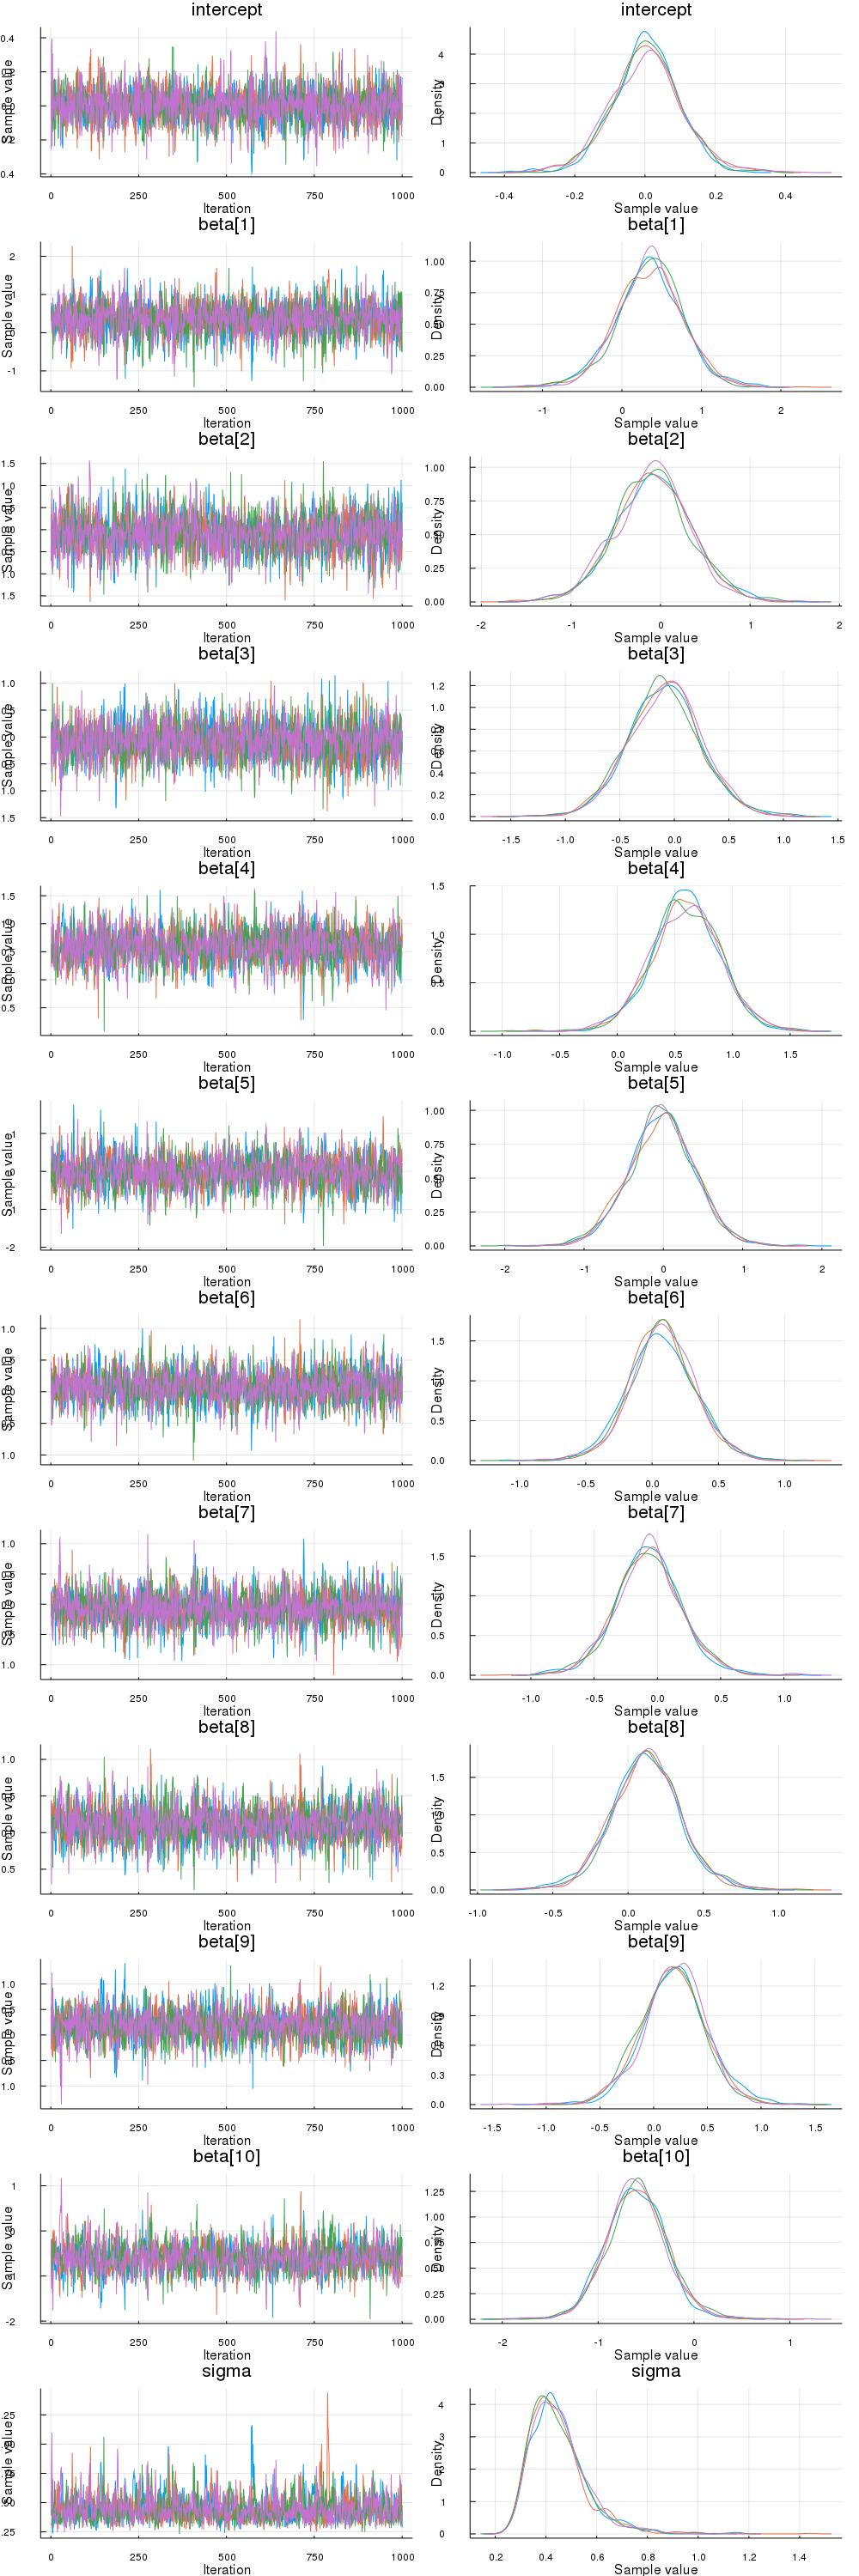

In [16]:
plot(chain)

Describe the chains.

In [17]:
describe(chain)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
               Mean         SD       Naive SE       MCSE      ESS
intercept  0.0037888101 0.09845982 0.0015567864 0.0013980498 1000
  beta[1]  0.3457669061 0.41541676 0.0065683156 0.0070487319 1000
  beta[2] -0.0842486248 0.42373924 0.0066999056 0.0078770617 1000
  beta[3] -0.0889726053 0.33469125 0.0052919333 0.0057469863 1000
  beta[4]  0.5932445347 0.29662991 0.0046901307 0.0051040244 1000
  beta[5] -0.0207945071 0.41751617 0.0066015103 0.0080789667 1000
  beta[6]  0.0773220340 0.24658017 0.0038987748 0.0039108721 1000
  beta[7] -0.0709386248 0.26288045 0.0041565048 0.0046073409 1000
  beta[8]  0.1203728379 0.22839114 0.0036111810 0.0045705922 1000
  beta[9]  0.1856693691 0.29596872 0.0046796763 0.0064255314 1000
 beta[10] -0.5977950854 0.31474844 0.0049766098 0.0064742376 1000
    sigma  0.4481626088 0.11188326 0.0017690297 0.0029345542 1000

Quantiles:
              

Perform multivariate OLS.

In [18]:
ols = lm(@formula(MPG ~ Cyl + Disp + HP + DRat + WT + QSec + VS + AM + Gear + Carb), train_cut)

┌ Warning: In the future eachcol will have names argument set to false by default
│   caller = evalcontrasts(::DataFrame, ::Dict{Any,Any}) at modelframe.jl:124
└ @ StatsModels /Users/rob/.julia/packages/StatsModels/AYB2E/src/modelframe.jl:124


StatsModels.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: MPG ~ 1 + Cyl + Disp + HP + DRat + WT + QSec + VS + AM + Gear + Carb

Coefficients:
                Estimate Std.Error   t value Pr(>|t|)
(Intercept)     -16.2329   24.1084 -0.673331   0.5146
Cyl              1.37966    1.3234   1.04251   0.3195
Disp         -0.00568808 0.0190498  -0.29859   0.7708
HP           -0.00844276 0.0323076 -0.261324   0.7987
DRat             6.90734   2.90389   2.37865   0.0366
WT             0.0789311   2.34318 0.0336854   0.9737
QSec            0.301514  0.889766  0.338869   0.7411
VS             -0.893479   2.88043 -0.310189   0.7622
AM               1.65175   2.78618  0.592837   0.5653
Gear             2.34024   3.22176  0.726388   0.4828
Carb            -3.10837   1.41932  -2.19005   0.0510


Store our predictions in the original dataframe.

In [19]:
train_cut.OLSPrediction = predict(ols);
test_cut.OLSPrediction = predict(ols, test_cut);

┌ Warning: In the future eachcol will have names argument set to false by default
│   caller = evalcontrasts(::DataFrame, ::Dict{Symbol,StatsModels.ContrastsMatrix}) at modelframe.jl:124
└ @ StatsModels /Users/rob/.julia/packages/StatsModels/AYB2E/src/modelframe.jl:124


Make a prediction given an input vector.

In [20]:
function prediction(chain, x)
    α = chain[:, 1, :].value
    β = [chain[:, i, :].value for i in 2:11]
    return  mean(α) .+ x * mean.(β)
end

prediction (generic function with 1 method)

Calculate the predictions for the training and testing sets.

In [21]:
train_cut.BayesPredictions = unstandardize(prediction(chain, train), train_l_orig);
test_cut.BayesPredictions = unstandardize(prediction(chain, test), test_l_orig);

Show the first side rows of the modified dataframe.

In [22]:
first(test_cut, 6)

bayes_loss1 = sum((train_cut.BayesPredictions - train_cut.MPG).^2)
ols_loss1 = sum((train_cut.OLSPrediction - train_cut.MPG).^2)

bayes_loss2 = sum((test_cut.BayesPredictions - test_cut.MPG).^2)
ols_loss2 = sum((test_cut.OLSPrediction - test_cut.MPG).^2)

println("Training set:")
println("  Bayes loss: $bayes_loss1")
println("  OLS loss: $ols_loss1")

println("Test set:")
println("  Bayes loss: $bayes_loss2")
println("  OLS loss: $ols_loss2")

Training set:
  Bayes loss: 67.72263665586999
  OLS loss: 67.56037474764624
Test set:
  Bayes loss: 202.94712906711766
  OLS loss: 270.94813070761944


*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*